In [ ]:
# 1️⃣ Installer les dépendances
!pip install ultralytics roboflow --quiet

# 2️⃣ Importer les librairies
from roboflow import Roboflow
from ultralytics import YOLO
import os
from pathlib import Path
from PIL import Image

# 3️⃣ Connecter à Roboflow et télécharger le dataset YOLOv8
rf = Roboflow(api_key="pLowI6cnFlZwwNSoLNNs")
project = rf.workspace("maram-w47y3").project("doctor-prescription-nqh3k")
version = project.version(1)
dataset = version.download("yolov8-obb")  # format YOLOv8 oriented bounding boxes (ou YOLOv8 si normal)


# Télécharger dataset en YOLOv8 (bbox)
dataset = version.download("yolov8")
dataset_path = Path(dataset.location)
print("Chemin dataset:", dataset_path)
print("Contenu:", os.listdir(dataset_path))

# ⚠️ Astuce : si tes annotations ont 1777 classes, créer un fichier data.yaml avec une seule classe "medicament"
# Exemple de data.yaml minimal :
# train: train/images
# val: valid/images
# test: test/images
# nc: 1
# names: ['medicament']

# 4️⃣ Créer un modèle YOLOv8 léger
model = YOLO("yolov8n.pt")  # nano = léger pour Colab T4

# 5️⃣ Lancer l'entraînement (images plus petites et batch réduit)
results = model.train(
    data=os.path.join(dataset_path, "data.yaml"),
    epochs=50,          # plus long = meilleure convergence
    imgsz=640,           # plus grande image = meilleure détection des petits détails
    batch=8,
    lr0=0.001,           # learning rate ajusté (évite la perte qui stagne)
    optimizer='AdamW',   # plus stable pour petits datasets
    patience=30,         # early stopping intelligent
    mosaic=0.5,          # garde un peu d’augmentation sans trop de mélange
    mixup=0,             # désactive mixup pour éviter les textes superposés
    degrees=2.0,         # petite rotation
    translate=0.05,      # légers déplacements
    scale=0.5,           # zoom modéré
    shear=1.0,           # légère inclinaison
    flipud=0.0,          # pas besoin de retournement vertical
    fliplr=0.5,          # horizontaux ok
    project="medicament_detection",
    name="yolo_medicament_v2",
    exist_ok=True
)


# 6️⃣ Évaluer le modèle
metrics = model.val(
    data=os.path.join(dataset_path, "data.yaml"),
    batch=8
)
print(metrics)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 72.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Doctor-prescription-1 in yolov8-obb:: 100%|██████████| 16221/16221 [00:02<00:00, 6729.37it/s]


Chemin dataset: /content/Doctor-prescription-1
Contenu: ['data.yaml', 'valid', 'train', 'test', 'README.roboflow.txt']
Ultralytics 8.3.213 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Doctor-prescription-1/data.yaml, degrees=2.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=yolo_medic

In [ ]:
# 7️⃣ Détection sur une image test
test_image = "L3_Scan_01.jpg"  # remplace par ton image
results = model.predict(
    source=test_image,
    conf=0.5,  # seuil confiance
    save=True, # sauvegarde l'image avec bbox
    project="medicament_detection",
    name="predictions"
)

# 8️⃣ Extraire automatiquement les crops pour OCR
output_dir = Path("medicament_detection/predictions/crops")
output_dir.mkdir(parents=True, exist_ok=True)

for r in results:
    boxes = r.boxes.xyxy.cpu().numpy()  # coordonnées [x1, y1, x2, y2]
    img = Image.open(test_image)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        crop = img.crop((x1, y1, x2, y2))
        crop.save(output_dir / f"crop_{i}.jpg")

print(f"Crops sauvegardés dans {output_dir}")



image 1/1 /content/L3_Scan_01.jpg: 640x640 10 MedicineNames, 7.8ms
Speed: 6.7ms preprocess, 7.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/medicament_detection/predictions
Crops sauvegardés dans medicament_detection/predictions/crops


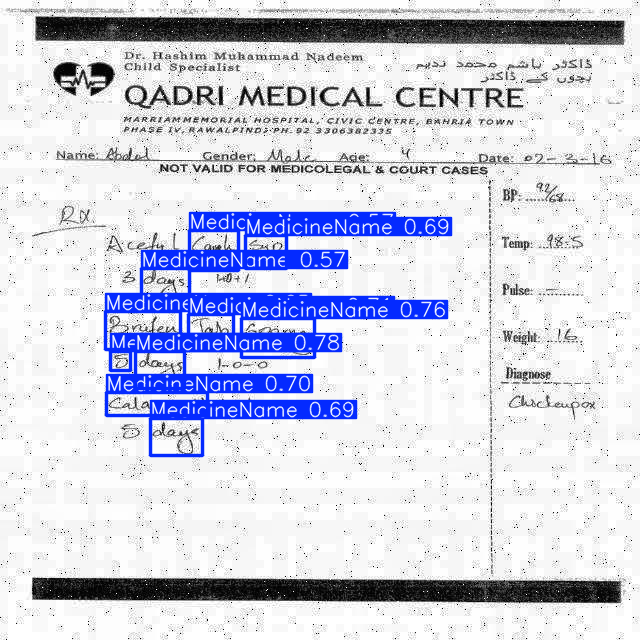

In [ ]:
# Boucle sur chaque résultat pour afficher les bboxes
for r in results:
    r.show()  # Affiche l'image avec les boîtes de détection
